In [ ]:
!pip install transformers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup, AdamW

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# loading the dataset
dataset = pd.read_csv('/content/drive/MyDrive/fake reviews dataset.csv')

In [ ]:
class_names = list(np.unique(dataset["label"]))
class_names

['CG', 'OR']

In [ ]:
encoder = OrdinalEncoder()
dataset["label"] = encoder.fit_transform(dataset[["label"]])

In [ ]:
df_train, df_test = train_test_split(dataset, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(32345, 4) (4043, 4) (4044, 4)


In [ ]:
amazon_reviews = pd.read_csv('/content/drive/MyDrive/Model_2_dataset.csv')

In [ ]:
amazon_reviews.columns

Index(['reviews', 'labels'], dtype='object')

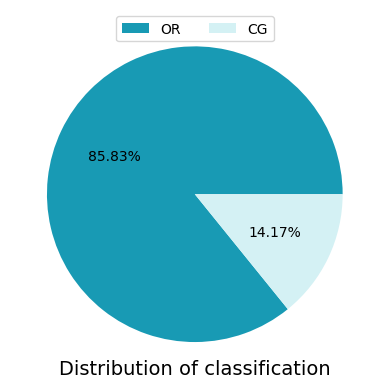

In [ ]:
colors = ['#189AB4', '#D4F1F4']
plt.pie(amazon_reviews["labels"].value_counts(), autopct='%0.2f%%',colors=colors)

plt.title('Distribution of classification', size=14, y=-0.01)
plt.legend(class_names[::-1], ncol=2, loc=9)
plt.show()

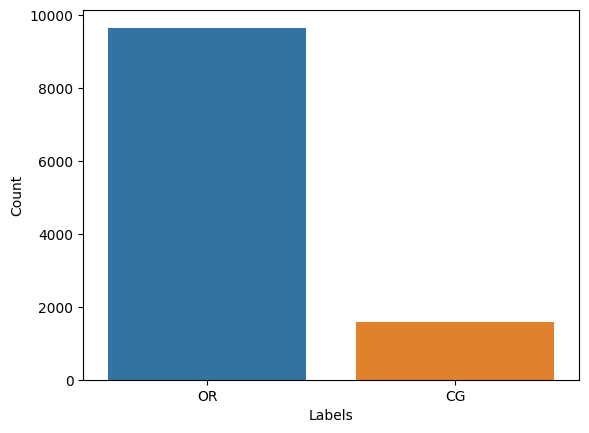

In [ ]:
count_label = amazon_reviews["labels"].value_counts()
sns.barplot(x=np.array(class_names[::-1]),y=count_label.values)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

Text(0.5, 0, 'Token count')

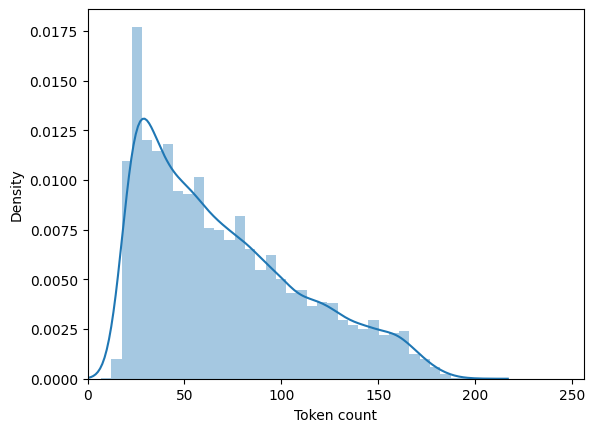

In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(amazon_reviews.reviews)

token_lens = np.sum(X.toarray(), axis = 1)

sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [ ]:
class AmazonReviewDataset(Dataset):
    def __init__(self,reviews,targets,tokenizer,max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self,item):
        review = str(self.reviews[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation = True,
            pad_to_max_length=True,
            return_tensors='pt',
            )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
            }

In [ ]:
def create_data_loader(df,tokenizer,max_len,batch_size):
    ds = AmazonReviewDataset(
        reviews = df.reviews.to_numpy(),
        targets = df.labels.to_numpy(),
        tokenizer = tokenizer,
        max_len=max_len)

    return DataLoader(ds,
                      batch_size=batch_size)

In [ ]:
def train_epoch(model, data_loader, optimizer, device, scheduler, batch_size):
    model = model.train()
    losses = 0
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=targets)

        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1)
        loss = outputs.loss
        correct_predictions += torch.sum(preds == targets).item() / batch_size
        losses += loss

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    train_loss = (losses/len(data_loader)).item()
    train_acc = correct_predictions/len(data_loader)

    return train_acc , train_loss

In [ ]:
def eval_model(model, data_loader, device, batch_size):
    model = model.eval()

    losses = 0
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=targets
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            loss = outputs.loss

            correct_predictions += torch.sum(preds == targets).item() / batch_size
            losses += loss

    val_loss = (losses/len(data_loader)).item()
    val_acc = correct_predictions/len(data_loader)

    return val_acc , val_loss

In [ ]:
def test_set_predictions(model, data_loader):
    model = model.eval()

    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=targets
            )

            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            predictions.extend(preds)
            prediction_probs.extend(logits)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return predictions, prediction_probs, real_values

In [ ]:
df_train_A, df_val_A = train_test_split(amazon_reviews, test_size=0.2, random_state=RANDOM_SEED)
print(df_train_A.shape, df_val_A.shape)

(8997, 2) (2250, 2)


In [ ]:
df_test = df_test.rename(columns={'text_': 'reviews'})
df_test = df_test.rename(columns={'label': 'labels'})
df_test.head()

,category,rating,labels,reviews
38420,Clothing_Shoes_and_Jewelry_5,5.0,1.0,My 82 year old dad is so old school and he lov...
15101,Movies_and_TV_5,5.0,1.0,Ill admit some of the changes in the special e...
32456,Books_5,5.0,1.0,Jules Feiffer is characteristically hilarious ...
40134,Clothing_Shoes_and_Jewelry_5,4.0,0.0,I've been wearing these boots for a couple yea...
35752,Toys_and_Games_5,4.0,0.0,I bought this on a whim for my son's third bir...


### Training with the max of length is 180 and the batch size is 64

In [ ]:
MAX_LEN = 180
BATCH_SIZE = 64
# Set the model name
MODEL_NAME = 'bert-base-uncased'

# Build a BERT based tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load the basic BERT model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Split Amazon dataset into the training set and validation set, corresponding 80% and 20%, respectively.
train_data_loader = create_data_loader(df_train_A, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val_A, tokenizer, MAX_LEN, BATCH_SIZE)
# Using the test set from the original dataset
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
# Number of iterations
EPOCHS = 5

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=5e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
history = {'train_loss': [],
           'train_acc': [],
           'val_loss': [],
           'val_acc': []}
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        BATCH_SIZE
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        BATCH_SIZE
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.2698637843132019 accuracy 0.8905141843971631
Val   loss 0.17621058225631714 accuracy 0.9127604166666666

Epoch 2/5
----------
Train loss 0.10471685975790024 accuracy 0.9611037234042553
Val   loss 0.21741269528865814 accuracy 0.9066840277777778

Epoch 3/5
----------
Train loss 0.035526517778635025 accuracy 0.9853723404255319
Val   loss 0.28366079926490784 accuracy 0.9097222222222222

Epoch 4/5
----------
Train loss 0.008707478642463684 accuracy 0.9940159574468085
Val   loss 0.3741348385810852 accuracy 0.8967013888888888

Epoch 5/5
----------
Train loss 0.0006565835792571306 accuracy 0.9967863475177305
Val   loss 0.32014957070350647 accuracy 0.9127604166666666



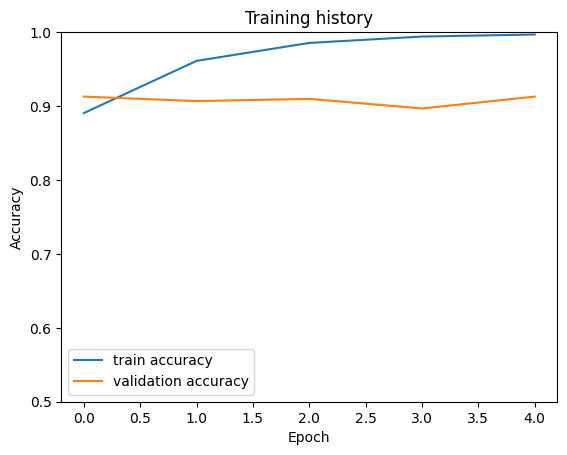

In [ ]:
# Plot training and validation accuracy
plt.plot( history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);

In [ ]:
y_pred, y_pred_probs, y_test = test_set_predictions(
    model,
    test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          CG       0.75      0.98      0.85      2017
          OR       0.97      0.68      0.80      2027

    accuracy                           0.83      4044
   macro avg       0.86      0.83      0.82      4044
weighted avg       0.86      0.83      0.82      4044



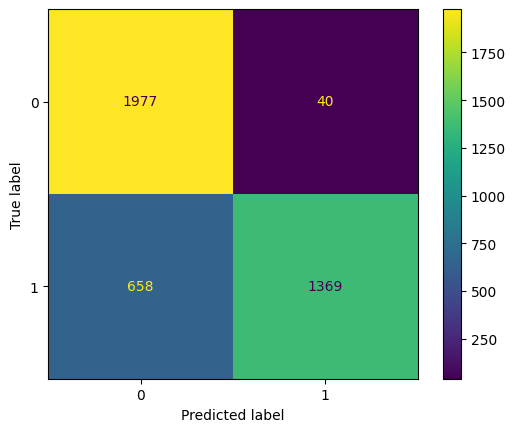

In [ ]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

### Training with the max of length is 160 and the batch size is 64

In [ ]:
MAX_LEN = 160
BATCH_SIZE = 64
# Set the model name
MODEL_NAME = 'bert-base-uncased'

# Build a BERT based tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load the basic BERT model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model = model.to(device)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Number of iterations
EPOCHS = 5

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)


In [ ]:
history = {'train_loss': [],
           'train_acc': [],
           'val_loss': [],
           'val_acc': []}
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        optimizer,
        device,
        scheduler,
        BATCH_SIZE
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        device,
        BATCH_SIZE
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.2400904893875122 accuracy 0.900709219858156
Val   loss 0.19895358383655548 accuracy 0.8888888888888888

Epoch 2/5
----------
Train loss 0.06305962800979614 accuracy 0.9731826241134752
Val   loss 0.1894601434469223 accuracy 0.9201388888888888

Epoch 3/5
----------
Train loss 0.02141369692981243 accuracy 0.990802304964539
Val   loss 0.23589105904102325 accuracy 0.9244791666666666

Epoch 4/5
----------
Train loss 0.006063374225050211 accuracy 0.9956781914893617
Val   loss 0.33572012186050415 accuracy 0.9092881944444444

Epoch 5/5
----------
Train loss 0.0002563628659117967 accuracy 0.9970079787234043
Val   loss 0.28031647205352783 accuracy 0.9227430555555556



In [ ]:
#Saving the model:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "DL_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: models/DL_model_2.pth


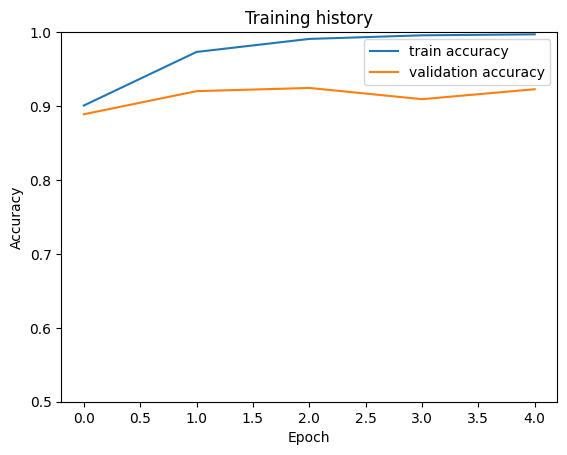

In [ ]:
# Plot training and validation accuracy
plt.plot( history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0.5, 1]);

In [ ]:
y_pred, y_pred_probs, y_test = test_set_predictions(
    model,
    test_data_loader)
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

          CG       0.77      0.98      0.86      2017
          OR       0.97      0.71      0.82      2027

    accuracy                           0.84      4044
   macro avg       0.87      0.84      0.84      4044
weighted avg       0.87      0.84      0.84      4044



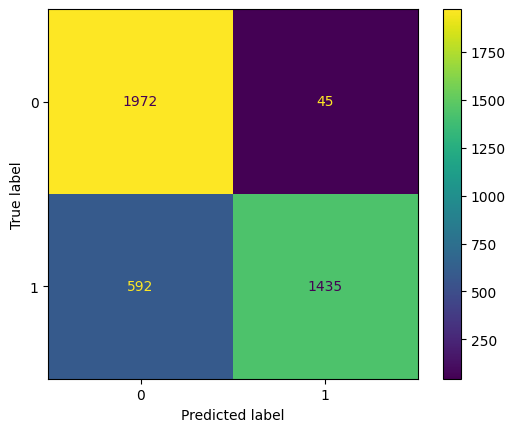

In [ ]:
# plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
# running time: 21 minutes.
info_memory = torch.cuda.mem_get_info()
memory = info_memory[1] - info_memory[0]
print("The total used memory is ", round(memory/2**30,2)," GB")

The total used memory is  10.51  GB
